In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('ticks',
              rc={'axes.facecolor': (0, 0, 0, 0)})
sns.set_context('talk')

from matplotlib import rcParams, colors, cm
rcParams['font.family'] = 'sans-serif'
rcParams['figure.dpi'] = 150

In [2]:
import os
import warnings
import numpy as np
import pandas as pd
from scipy import stats
# local import
from utils import read_mi

In [3]:
def merge_mi_epi(mi, epi, threshold=0.15):
    j = pd.DataFrame(np.array([mi, epi]).T,
                     columns=['mi', 'epistasis'])
    
    tp = j[(j['mi'] > 0) & (abs(j['epistasis']) >= threshold)].shape[0]
    fp = j[(j['mi'] > 0) & (abs(j['epistasis']) < threshold)].shape[0]
    tn = j[(j['mi'] == 0) & (abs(j['epistasis']) < threshold)].shape[0]
    fn = j[(j['mi'] == 0) & (abs(j['epistasis']) >= threshold)].shape[0]

    return (tp, fp, tn, fn)

def get_specificity(mi, epi, threshold=0.4):
    tp, fp, tn, fn = merge_mi_epi(mi, epi, threshold)

    try:
        spec = tn / (tn + fp)
    except ZeroDivisionError:
        spec = np.nan

    return spec

def get_recall(mi, epi, threshold=0.4):
    tp, fp, tn, fn = merge_mi_epi(mi, epi, threshold)

    try:
        recall = tp / (tp + fn)
    except ZeroDivisionError:
        recall = np.nan

    return recall

def get_f1(mi, epi, threshold=0.4):
    tp, fp, tn, fn = merge_mi_epi(mi, epi, threshold)

    try:
        f1 = 2 * tp / (2 * tp + fp + fn)
    except ZeroDivisionError:
        f1 = np.nan

    return f1

In [4]:
def validate_epistasis(df, m, name, kind='filtered', outlier=1):
    df = df[(df['gene_source'] == 'S') &
            (df['gene_target'] == 'S') &
            (df['outlier'] >= outlier)].copy()
    
    df['feature_codon_source'] = df['feature_codon_source'].astype(int)
    df['feature_codon_target'] = df['feature_codon_target'].astype(int)
    
    df = df.groupby(['feature_codon_source',
                     'feature_codon_target'])['mi'].max()
    df.index.names = ['pos1', 'pos2']
    j = m.to_frame().rename(columns={0: 'epistasis'}
                           ).join(df.to_frame().rename(columns={0: 'mi'}),
                                  how='left')
    j = j.fillna(0)
    
    mi = j['mi'].values
    epi = j['epistasis'].values

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        spec = get_specificity(mi, epi)
        ci = stats.bootstrap((mi, epi), get_specificity, paired=True,
                             n_resamples=999)
        sl, sh = ci.confidence_interval.low, ci.confidence_interval.high
        # print(precision, pl, ph)
        recall = get_recall(mi, epi)
        ci = stats.bootstrap((mi, epi), get_recall, paired=True,
                             n_resamples=999)
        rl, rh = ci.confidence_interval.low, ci.confidence_interval.high
        # print(recall, rl, rh)
        f1 = get_f1(mi, epi)
        ci = stats.bootstrap((mi, epi), get_f1, paired=True,
                             n_resamples=999)
        fl, fh = ci.confidence_interval.low, ci.confidence_interval.high
        # print(f1, fl, fh)

    res = []
    res.append(pd.DataFrame([[name, kind, outlier,
                              'f1', f1, fl, fh]],
                        columns=['name', 'kind', 'outlier',
                                 'metric', 'value', 'low', 'high']))
    res.append(pd.DataFrame([[name, kind, outlier,
                              'specificity', spec, sl, sh]],
                        columns=['name', 'kind', 'outlier',
                                 'metric', 'value', 'low', 'high']))
    res.append(pd.DataFrame([[name, kind, outlier,
                              'sensitivity', recall, rl, rh]],
                        columns=['name', 'kind', 'outlier',
                                 'metric', 'value', 'low', 'high']))
    return pd.concat(res)

In [5]:
m = pd.read_csv('coefficients_2nd_order.tsv', sep='\t')

m['pos1'] = [int(x[1:-1]) for x in m['Term 1'].values]
m['pos2'] = [int(x[1:-1]) for x in m['Term 2'].values]

m = m.pivot_table(index='pos1', columns='pos2', values='Coefficient')
m = m.mask(np.triu(np.ones(m.shape)).astype(bool)).stack()

In [6]:
res = []
name = 'all'
df = read_mi('../out/all-notime/mi_annotated.tsv.gz',
             name,
             date=False)
for ol in range(1, 5):
    res.append(validate_epistasis(df, m, name, 'filtered', ol))
pd.concat(res)

,name,kind,outlier,metric,value,low,high
0,all,filtered,1,f1,0.285714,0.000000,0.666667
0,all,filtered,1,specificity,0.930000,0.870000,0.970297
0,all,filtered,1,sensitivity,0.400000,NaN,NaN
0,all,filtered,2,f1,0.285714,0.000000,0.666667
0,all,filtered,2,specificity,0.930000,0.860729,0.969697
0,all,filtered,2,sensitivity,0.400000,NaN,NaN
0,all,filtered,3,f1,0.285714,0.000000,0.666667
0,all,filtered,3,specificity,0.930000,0.860098,0.970000
0,all,filtered,3,sensitivity,0.400000,NaN,NaN
0,all,filtered,4,f1,0.285714,0.000000,0.666667


In [7]:
res = []
for name in [1_000, 10_000,
             100_000, 1_000_000]:
    df = read_mi(f'../out/subsets-notime/{name}/mi_annotated.tsv.gz',
                 name,
                 date=False)
    for ol in range(1, 5):
        res.append(validate_epistasis(df, m, name, 'filtered', ol))
pd.concat(res)

,name,kind,outlier,metric,value,low,high
0,1000,filtered,1,f1,0.500000,0.235294,0.751658
0,1000,filtered,1,specificity,0.900000,0.833240,0.950495
0,1000,filtered,1,sensitivity,1.000000,NaN,NaN
0,1000,filtered,2,f1,0.266667,0.000000,0.666667
0,1000,filtered,2,specificity,0.920000,0.850000,0.961165
0,1000,filtered,2,sensitivity,0.400000,NaN,NaN
0,1000,filtered,3,f1,0.285714,0.000000,0.666667
0,1000,filtered,3,specificity,0.930000,0.858817,0.969446
0,1000,filtered,3,sensitivity,0.400000,NaN,NaN
0,1000,filtered,4,f1,0.285714,0.000000,0.666667


In [8]:
res = []
for name in sorted(os.listdir('../out/time-filtered-subsets/')):
    try:
        print(name)
        df = read_mi(f'../out/time-filtered-subsets/{name}/mi_annotated.tsv.gz',
                     name,
                     date=True)
        for ol in range(1, 5):
            res.append(validate_epistasis(df, m, name, 'filtered', ol))
        # df = read_mi(f'../out/time-filtered-subsets/{name}/mi_annotated_prefilter.tsv.gz',
        #              name,
        #              date=True)
        # for ol in range(1, 5):
        #     res.append(validate_epistasis(df, m, name, 'raw', ol))
    except FileNotFoundError:
        pass

2020-03
2020-04
2020-05
2020-06
2020-07
2020-08
2020-09
2020-10
2020-11
2020-12
2021-01
2021-02
2021-03
2021-04
2021-05
2021-06
2021-07
2021-08
2021-09
2021-10
2021-11
2021-12
2022-01
2022-02
2022-03
2022-04
2022-05
2022-06
2022-07
2022-08
2022-09
2022-10
2022-11
2022-12
2023-01
2023-02
2023-03


In [9]:
r = pd.concat(res)

In [10]:
r.to_csv('time_epistasis_ml_metrics.tsv', sep='\t')

/home/marco/miniconda3/envs/epistasis/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/marco/miniconda3/envs/epistasis/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/home/marco/miniconda3/envs/epistasis/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/marco/miniconda3/envs/epistasis/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/home/marco/miniconda3/envs/epistasis/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/marco/miniconda3/envs/epistasis/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: Ru

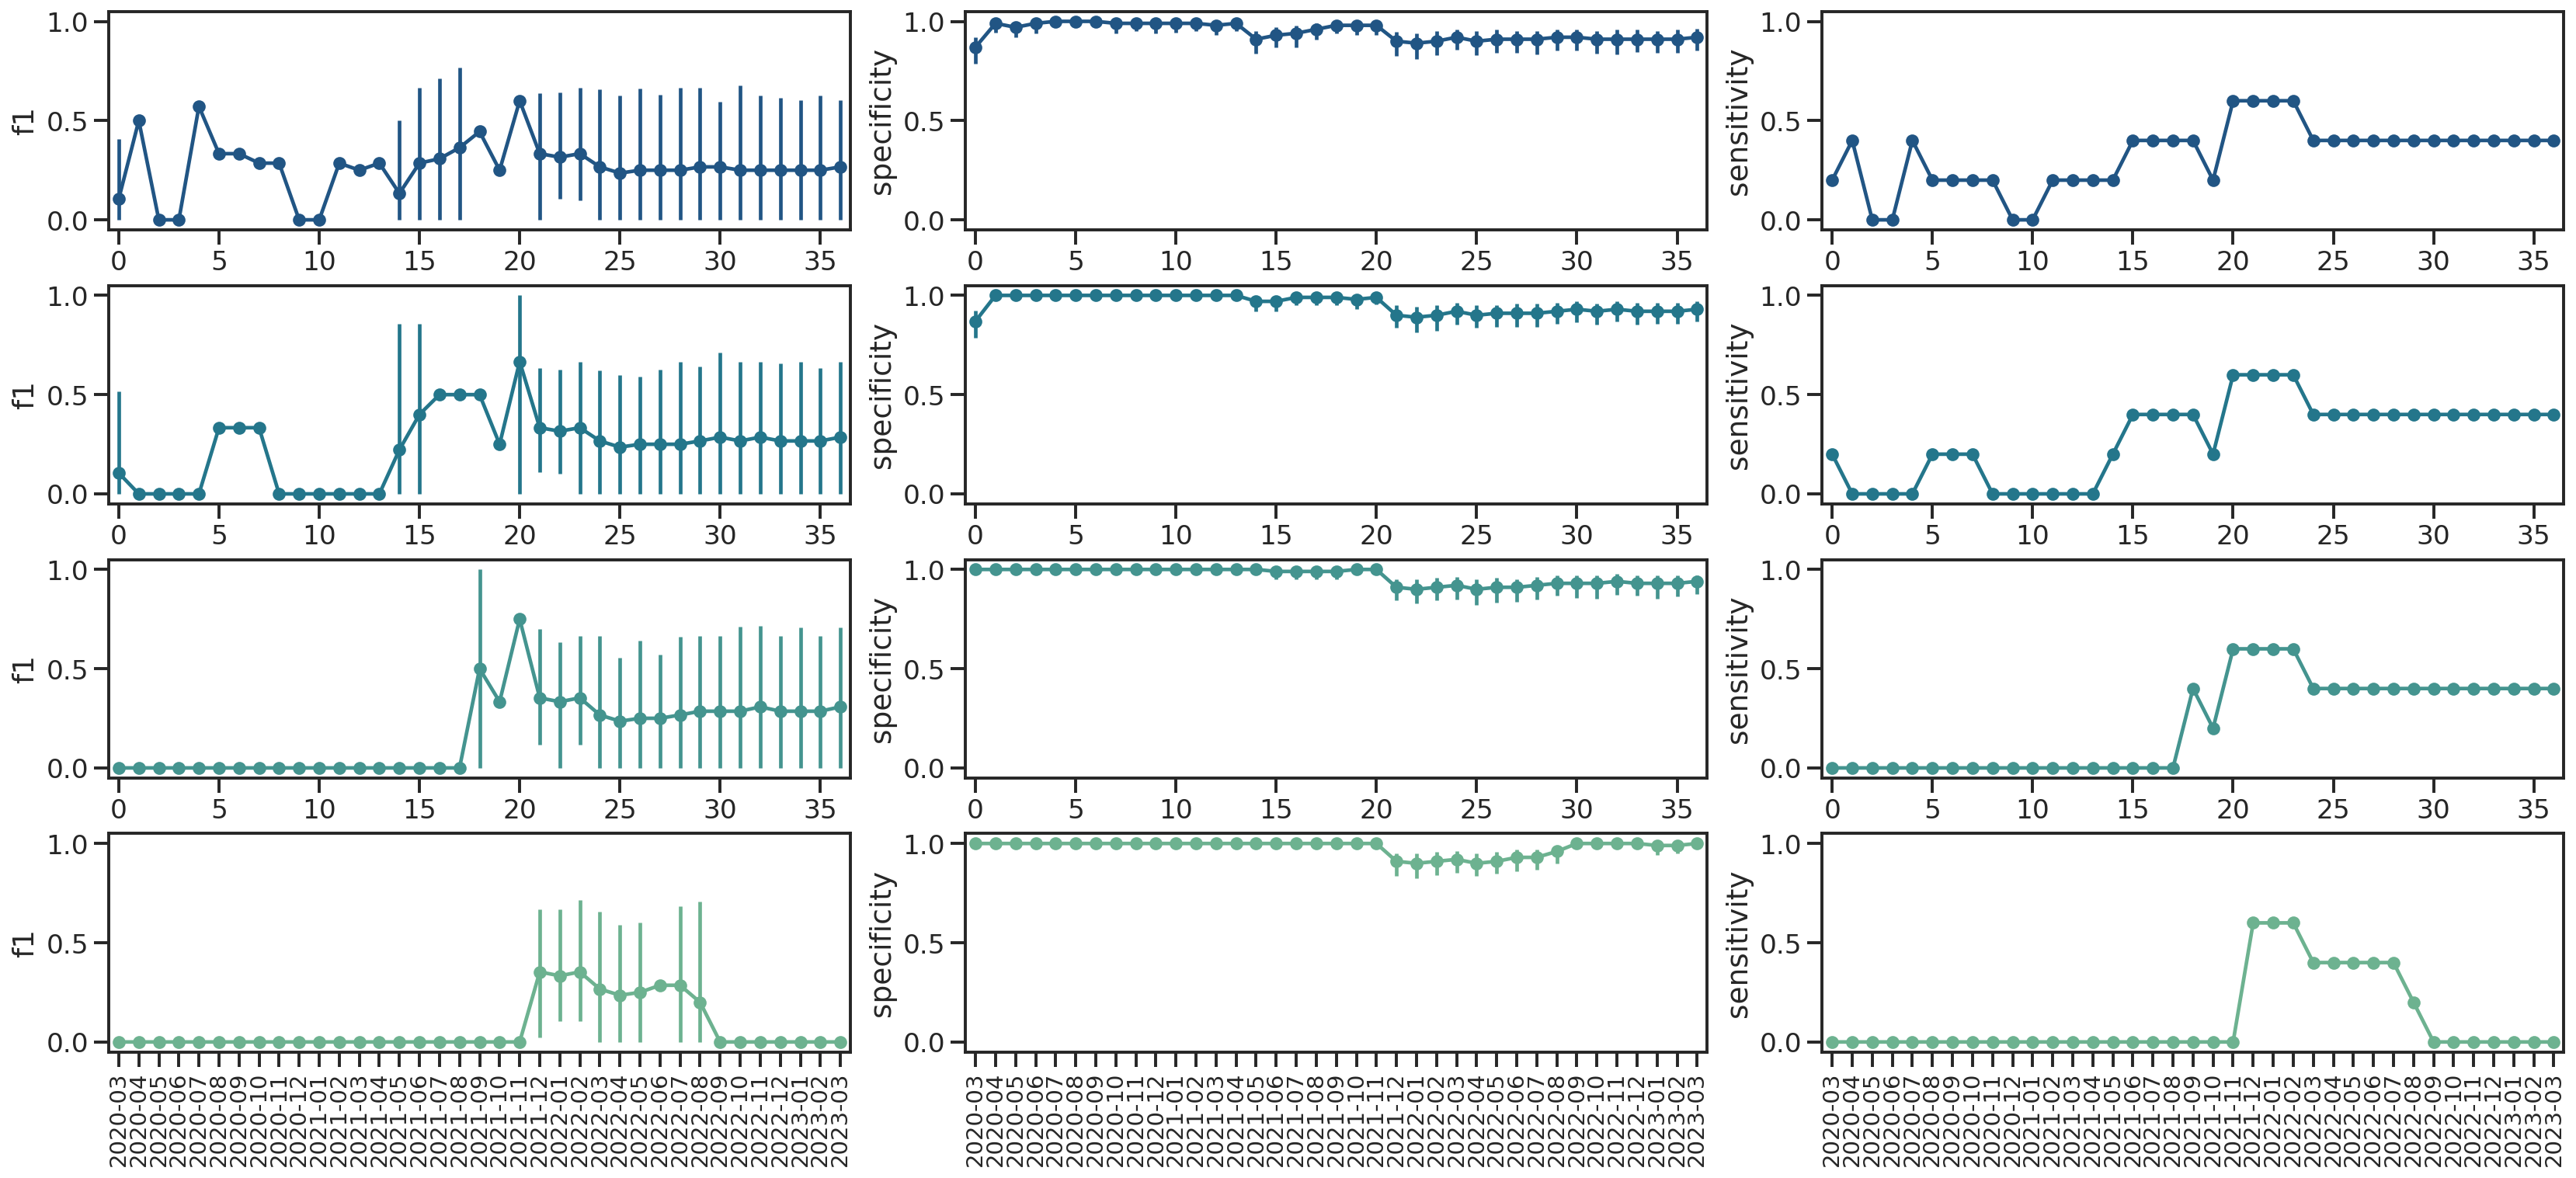

In [11]:
fig, axes = plt.subplots(4, 3, figsize=(22, 10),
                         constrained_layout=True)

for col, metric in zip(range(3),
                       ('f1', 'specificity', 'sensitivity')):
    for row, ol, color in zip(range(4), range(1, 5),
                              sns.color_palette('crest_r', 4)):
        ax = axes[row][col]
        t = r[(r['metric'] == metric) &
              (r['outlier'] == ol) &
              (r['kind'] == 'filtered')]
        ax.errorbar(range(t['name'].unique().shape[0]),
                    t['value'],
                    yerr=abs(t[['low', 'high']].T.values -
                             t['value'].values),
                    color=color, zorder=-1, fmt='o-',
                    markersize=7)
        ax.set_ylim(-0.05, 1.05)
        ax.set_ylabel(metric)
        ax.set_xlim(-0.5, r['name'].unique().shape[0] - 0.5)
        if row == 3:
            ax.set_xticks(range(r['name'].unique().shape[0]),
                          labels=r['name'].unique(),
                          rotation=90,
                          fontsize=14)

plt.savefig('epistasis.png',
            dpi=300,
            bbox_inches='tight',
            transparent=True)
plt.savefig('epistasis.svg',
            dpi=300,
            bbox_inches='tight',
            transparent=True);